<a href="https://colab.research.google.com/github/orekhovsky/GenAI-mini-projects/blob/main/Transfer_learning_resnet50%2Bmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [4]:
# 1. Подготовка данных
# Преобразуем изображения MNIST (одноцветные) в формат с тремя каналами, увеличиваем размер до 224x224
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Преобразование в трехканальное изображение
    transforms.Resize((224, 224)),                # Изменение размера под ResNet50
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
# 2. Выбор предобученной модели и адаптация
# Используем ResNet50 с предобученными весами, замораживаем базовые слои и меняем классификатор
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Заморозка параметров базовой сети

# Заменяем последний полностью связанный слой, чтобы получить 10 классов (цифры от 0 до 9)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10)
)

# Перенос модели на GPU, если он доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# 3. Обучение модели
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Обучаем только изменённые слои

train_losses = []
train_accuracies = []

def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')
    return all_labels, all_preds

train(model, train_loader, criterion, optimizer, epochs=5)
labels, preds = evaluate(model, test_loader)

Epoch 1, Loss: 0.5181, Accuracy: 0.8353
Epoch 2, Loss: 0.3149, Accuracy: 0.9000
Epoch 3, Loss: 0.2840, Accuracy: 0.9081
Epoch 4, Loss: 0.2601, Accuracy: 0.9160
Epoch 5, Loss: 0.2502, Accuracy: 0.9184
Accuracy: 0.9488


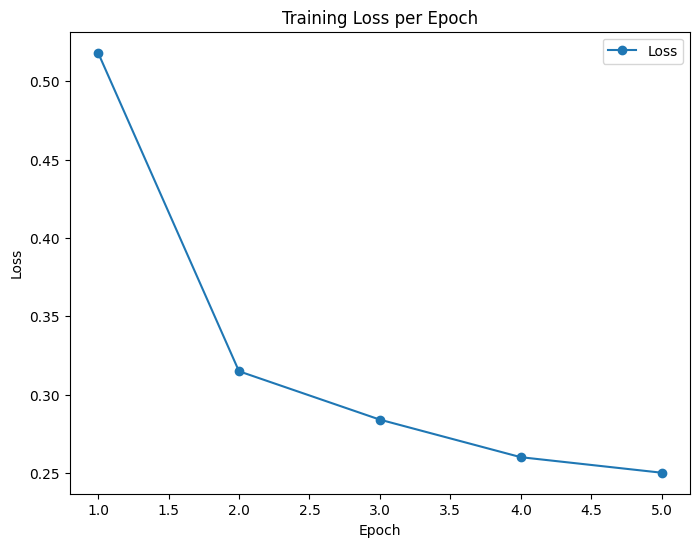

In [10]:
# График потерь
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()


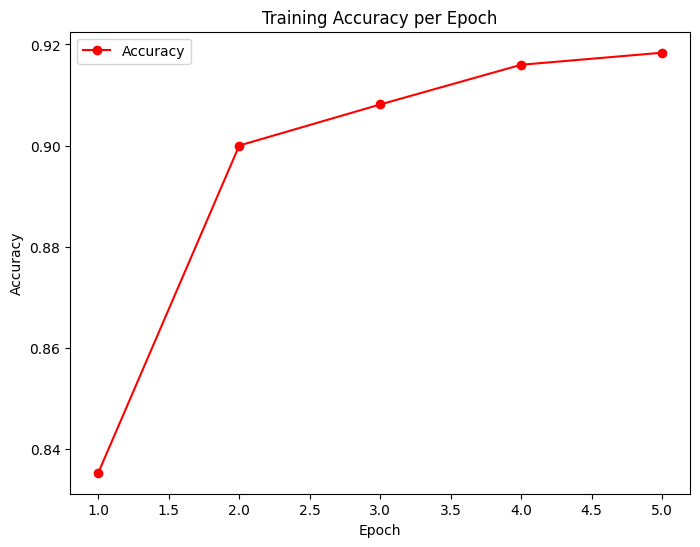

In [11]:
# График точности
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, marker='o', color='r', label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()
plt.show()

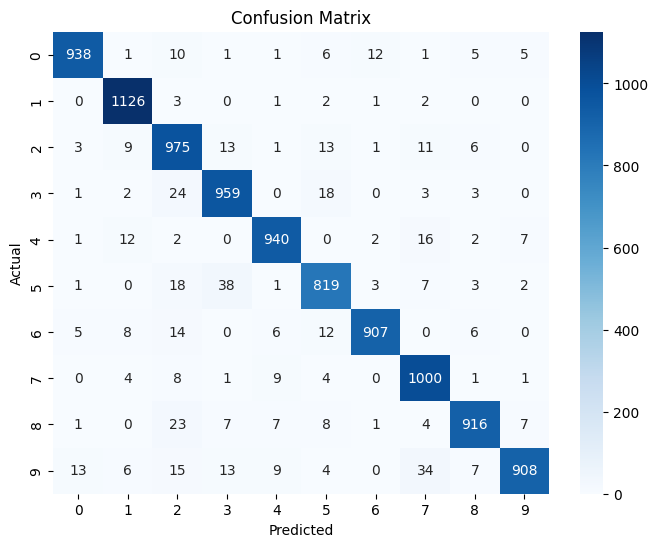

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(labels, preds)

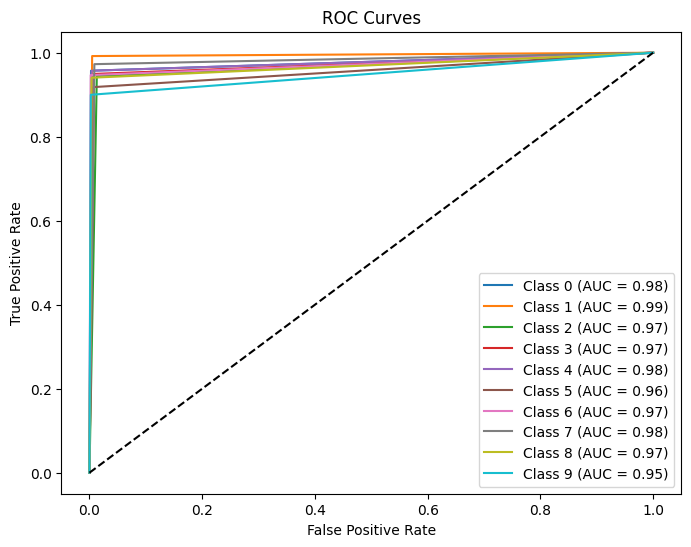

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Бинаризуем метки
y_test_binarized = label_binarize(labels, classes=range(10))
y_pred_binarized = label_binarize(preds, classes=range(10))

plt.figure(figsize=(8, 6))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Диагональ случайной модели
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda
